In this Notebook, I will play with the [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor), a Neural Networks based regressor used for prediction of continuous results.

This Machine Learning model is based on at least three layers neural network:

- input and output layers, based on shapes of the input feature and output results. We can not change any parameters for this two layers.

- One or more hidden layers that can be defined using the *hidden_layer_sizes* parameter.

Which hidden layer sizes should I define ?

This is the role of the grid search here, try to find the best combination of layers to obtain the best performance.

Along with the *hidden_layer_sizes* parameters, there is some more parameters to play with to optimize the model: activation and solver algorythm, alpha, the L2 penalty, and many more.

What I'll do in this Notebook is first a randomized search with a fix *alpha* value set to default ($10^{-4}$) to identify wich values I should use for the other parameters, especially the *hidden_layer_size* one. When this is done, I will vary the *alpha* parameter in a grid search to find the best estimator.


In [1]:
# Load my_utils.ipynb in Notebook
from ipynb.fs.full.my_utils import *

Opening connection to database
Add pythagore() function to SQLite engine
Fraction of the dataset used to train models: 10.00%
my_utils library loaded :-)


# Import usefull libraries

In [2]:
# Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# PCA
from sklearn.decomposition import PCA

# Grid Search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# MLPRegressor Model
from sklearn.neural_network import MLPRegressor

# Load train/valid data

Nothing special here, use the *loadXy()* function to load train/valid X and y datasets

In [3]:
# Load X and y
X_tr, y_tr, X_va, y_va=load_Xy(frac=FRAC_VALUE_FOR_ML)


# Grid Search

## Define pipeline and grid parameters

Scaler and PCA will be configured in the Pipeline and manage as grid parameters:

### Scaler

Scaler will not be disabled during the grid search, otherwise the model training process might fail due to inifinite value error. So the *None* choice will be excluded from the search process.

- StandardScaler()

- MinMaxScaler()

- RobustScaler()


### PCA

The pipeline will be configured to let the search process to disable the PCA (setting *None* in grid parameter) and use the following definitions:

- PCA(0.8)

- PCA(0.9)

- PCA(0.95)



In [4]:
# Define list of scaler used in grid search
scalers=[StandardScaler(), MinMaxScaler(), RobustScaler()]

# Define list of PCA reduction used in grid search
pcas=[PCA(0.8), PCA(0.9), PCA(0.95), None]

In [5]:
# Initialize Ridge ML model
model = MLPRegressor()

# Define pipeline with scaler, pca and model choosen
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("model", model),
])

# Define base grid search parameters
param_grid = {
    "scaler": scalers,
    "pca": pcas
}



## RandomizedSearchCV with large parameters scope

For this first randomized search, I will try to vary a lot of different parameters, except the *alpha* one that I will let to its default value $10^{-4}$:

- *hidden_layer_size*

- *solver* function

- *activation* function

### What value for *hidden_layer_size* parameter ?

I did found a good comment on [Stack Exchange](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw) wich gives a formula on how much neurons we should have max.

$N_{n}=\frac{N_{s}}{\alpha(N_{i}+N_{o})}$

with:

- N<sub>n</sub> = Maximum number of neurons.

- N<sub>i</sub> = number of input neurons.

- N<sub>o</sub> = number of output neurons.

- N<sub>s</sub> = number of samples in training data set.

- $\alpha$ = an arbitrary scaling factor usually 2-10. My choice will go to $\alpha=5$ 


In [6]:
# Fix alpha to scaling factor
alpha=5

# Set number of input neurons to number of features
n_i=X_tr.shape[1]

# Set number of output to 1 (only one result vector)
n_o=1

# Define number of samples in train dataset
n_s=X_tr.shape[0]

# Calculate the maximum neurons to use (convert to int type to get integer value)
max_neurons=int(n_s/(alpha*(n_i + n_o)))


print("Max neurons to use:", max_neurons)

Max neurons to use: 585


Ok, this function gives the maximum numbers of neuron I should define in my model, but what about the number of hidden layers and their respective size ?

This is where a randomized search could help. I will define all kind of possibilities using the *max_neurons* values by combining them into 1, 2 and 3 hidden layers.

Let's build a list of all that possibilites.

> Note: I will set the minimum number of neurons of 2 for each hidden layer defined

In [7]:
# Build a list based on range of max_neurons
neuron_list=list(range(2, max_neurons+1, 5))

# Build one layer structure
hidden_layers=neuron_list.copy()

# Build two layer structure
for i in neuron_list:
    for j in neuron_list:
        if i*j < max_neurons:
            hidden_layers.append((i,j))

# Build three layer structure
for i in neuron_list:
    for j in neuron_list:
        for k in neuron_list:
            if i*j*k < max_neurons+1:
                hidden_layers.append((i,j,k))

I can now define my grid search parameters and start the search process.

In [8]:
# Set specific model parameters to param_grid
param_grid["model__hidden_layer_sizes"]=hidden_layers
param_grid["model__activation"]=["identity", "logistic", "tanh", "relu"]
param_grid["model__solver"]=["lbfgs", "sgd", "adam"]
param_grid["model__alpha"]=[0.0001]

# Set the max_iter to a higher value than default to avoid missing convergence errors
param_grid["model__max_iter"]=[1000]

# Number of random search iterations (the more the slower ;-) )
ITERATIONS=100

# Initialize RandomizedSearchCV object. Note that return_train_score=True
random_search = RandomizedSearchCV(pipe, param_grid, scoring=custom_scorer, n_iter=ITERATIONS, random_state=RANDOM_STATE,
                                   n_jobs=-1, cv=5, verbose=1, return_train_score=True)

# Do the random hyperparameter tuning search
random_search.fit(X_tr, y_tr)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 104.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 164.4min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
      ...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'scaler': [StandardScaler(copy=True, with_mean=True, with_std=True), MinMaxScaler(copy=True, feature_range=(0, 1)), RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)], 'pca': [PCA(copy=True, iterated_power='auto', n_components=0....u'], 'model__solver': ['lbfgs', 'sgd', 'adam'], 'model__alpha': [0.0001], 'model__max_iter': [1000]},
          pr

### Results

Display results as a *pd.DataFrame*, sorted by *mean_test_score*.

In [9]:
# Build a dataframe from search.cv_results_
random_df=pd.DataFrame(random_search.cv_results_)

# Restrict to interesting columns
cols = [f'param_{key}' for key in param_grid.keys()]
cols+=['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']
random_df=random_df[cols]

# Print result
print("Best parameters found:", random_search.best_params_)
print("10 best results:")
random_df.sort_values('mean_test_score', ascending=False).head(10)



Best parameters found: {'scaler': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True), 'pca': PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 'model__solver': 'lbfgs', 'model__max_iter': 1000, 'model__hidden_layer_sizes': (82, 7), 'model__alpha': 0.0001, 'model__activation': 'tanh'}
10 best results:


,param_scaler,param_pca,param_model__hidden_layer_sizes,param_model__activation,param_model__solver,param_model__alpha,param_model__max_iter,mean_test_score,std_test_score,mean_train_score,std_train_score
21,"RobustScaler(copy=True, quantile_range=(25.0, ...","PCA(copy=True, iterated_power='auto', n_compon...","(82, 7)",tanh,lbfgs,0.0001,1000,89.628323,0.070906,89.804815,0.090836
59,"RobustScaler(copy=True, quantile_range=(25.0, ...",None,247,relu,lbfgs,0.0001,1000,89.511726,0.053237,90.411369,0.020481
53,"StandardScaler(copy=True, with_mean=True, with...",None,"(127, 2)",tanh,lbfgs,0.0001,1000,89.478863,0.051583,90.060253,0.075515
54,"StandardScaler(copy=True, with_mean=True, with...","PCA(copy=True, iterated_power='auto', n_compon...","(12, 12)",tanh,lbfgs,0.0001,1000,89.291827,0.112548,89.364894,0.060457
46,"RobustScaler(copy=True, quantile_range=(25.0, ...","PCA(copy=True, iterated_power='auto', n_compon...",382,relu,adam,0.0001,1000,89.257904,0.144561,89.592318,0.110451
96,"StandardScaler(copy=True, with_mean=True, with...","PCA(copy=True, iterated_power='auto', n_compon...",427,tanh,lbfgs,0.0001,1000,89.193455,0.052047,89.759281,0.036657
8,"RobustScaler(copy=True, quantile_range=(25.0, ...",None,"(97, 2)",tanh,adam,0.0001,1000,89.176912,0.065193,89.288227,0.053119
18,"RobustScaler(copy=True, quantile_range=(25.0, ...","PCA(copy=True, iterated_power='auto', n_compon...","(82, 2)",relu,adam,0.0001,1000,89.114149,0.160816,89.256688,0.133280
41,"StandardScaler(copy=True, with_mean=True, with...",None,"(12, 7)",tanh,lbfgs,0.0001,1000,89.074996,0.371477,89.169041,0.323249
45,"RobustScaler(copy=True, quantile_range=(25.0, ...",None,342,logistic,adam,0.0001,1000,88.969243,0.225623,89.026365,0.180687


### What can I do according to the above results ?

The results from this randomized search promotes *PCA(0.95)* transformation and *RobustScaler()* as the best pre-processing combination for that model.

Solver function choice looks clear as well: *lbfgs*.

For the activation function and the layer size, it's a bit unclear what's the best combination. It could be one layer and *relu* activation function, or two layers with *tanh* function.

My preference will go with two hidden layers *(82,7)* with *tanh* activation function as it is the combination that performs the best with *RobustScaler()* and *PCA(0.95)*

In conclusion, here are the parameters I will fix to refine my grid search on *alpha* parameter:

- *RobustScaler()*
- *PCA(0.95)*
- activation=*tanh*
- solver=*lbfgs*
- hidden_layers=*(82,7)*


### GridSearchCV on more precise parameter intervals

Build and run a *GridSearchCV* with reduced parameter scope, fixing scaler and PCA to *None*.

In [10]:
# Set specific model parameters to param_grid
param_grid["model__hidden_layer_sizes"]=[(82,7)]
param_grid["model__activation"]=["tanh"]
param_grid["model__solver"]=["lbfgs"]
param_grid["model__alpha"]=np.logspace(-5, 2, 50)


param_grid['scaler']=[RobustScaler()]
param_grid['pca']=[PCA(0.95)]


# Initialize GridSearchCV object. Note that return_train_score=True
grid_search = GridSearchCV(pipe, param_grid, scoring=custom_scorer, n_jobs=-1, cv=5, verbose=1, return_train_score=True)

# Do the grid search
grid_search.fit(X_tr, y_tr)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 156.9min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 199.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
      ...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'scaler': [RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)], 'pca': [PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)], 'model__hidden_layer_sizes': [(82, 7)], 'mode...       2.68270e+01, 3.72759e+01, 5.17947e+01, 7.19686e+01, 1.00000e+02]), 'model__max_iter': [1000]},
       pre_dispatch='2*n_jobs', refit=T

### Results

In [11]:
# Build a dataframe from search.cv_results_
grid_df=pd.DataFrame(grid_search.cv_results_)

# Restrict to interesting columns
cols = [f'param_{key}' for key in param_grid.keys()]
cols+=['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']

# Restrict to interesting columns
grid_df=grid_df[cols]

print("Best parameters found:", grid_search.best_params_)
print("10 best results:")
grid_df.sort_values('mean_test_score', ascending=False).head(10)


Best parameters found: {'model__activation': 'tanh', 'model__alpha': 0.005179474679231208, 'model__hidden_layer_sizes': (82, 7), 'model__max_iter': 1000, 'model__solver': 'lbfgs', 'pca': PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 'scaler': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)}
10 best results:


,param_scaler,param_pca,param_model__hidden_layer_sizes,param_model__activation,param_model__solver,param_model__alpha,param_model__max_iter,mean_test_score,std_test_score,mean_train_score,std_train_score
19,"RobustScaler(copy=True, quantile_range=(25.0, ...","PCA(copy=True, iterated_power='auto', n_compon...","(82, 7)",tanh,lbfgs,0.00517947,1000,89.666126,0.082475,89.909088,0.043575
23,"RobustScaler(copy=True, quantile_range=(25.0, ...","PCA(copy=True, iterated_power='auto', n_compon...","(82, 7)",tanh,lbfgs,0.019307,1000,89.651655,0.042575,89.871219,0.066817
24,"RobustScaler(copy=True, quantile_range=(25.0, ...","PCA(copy=True, iterated_power='auto', n_compon...","(82, 7)",tanh,lbfgs,0.026827,1000,89.648758,0.085519,89.882346,0.054916
25,"RobustScaler(copy=True, quantile_range=(25.0, ...","PCA(copy=True, iterated_power='auto', n_compon...","(82, 7)",tanh,lbfgs,0.0372759,1000,89.647843,0.057062,89.852417,0.059214
21,"RobustScaler(copy=True, quantile_range=(25.0, ...","PCA(copy=True, iterated_power='auto', n_compon...","(82, 7)",tanh,lbfgs,0.01,1000,89.642011,0.061247,89.885367,0.041156
1,"RobustScaler(copy=True, quantile_range=(25.0, ...","PCA(copy=True, iterated_power='auto', n_compon...","(82, 7)",tanh,lbfgs,1.3895e-05,1000,89.637700,0.061635,89.863654,0.043442
6,"RobustScaler(copy=True, quantile_range=(25.0, ...","PCA(copy=True, iterated_power='auto', n_compon...","(82, 7)",tanh,lbfgs,7.19686e-05,1000,89.630690,0.059697,89.843909,0.092532
17,"RobustScaler(copy=True, quantile_range=(25.0, ...","PCA(copy=True, iterated_power='auto', n_compon...","(82, 7)",tanh,lbfgs,0.0026827,1000,89.626846,0.060687,89.856719,0.037975
5,"RobustScaler(copy=True, quantile_range=(25.0, ...","PCA(copy=True, iterated_power='auto', n_compon...","(82, 7)",tanh,lbfgs,5.17947e-05,1000,89.624244,0.030528,89.850026,0.068684
0,"RobustScaler(copy=True, quantile_range=(25.0, ...","PCA(copy=True, iterated_power='auto', n_compon...","(82, 7)",tanh,lbfgs,1e-05,1000,89.624235,0.065106,89.839387,0.081099


### Graphical representation of results

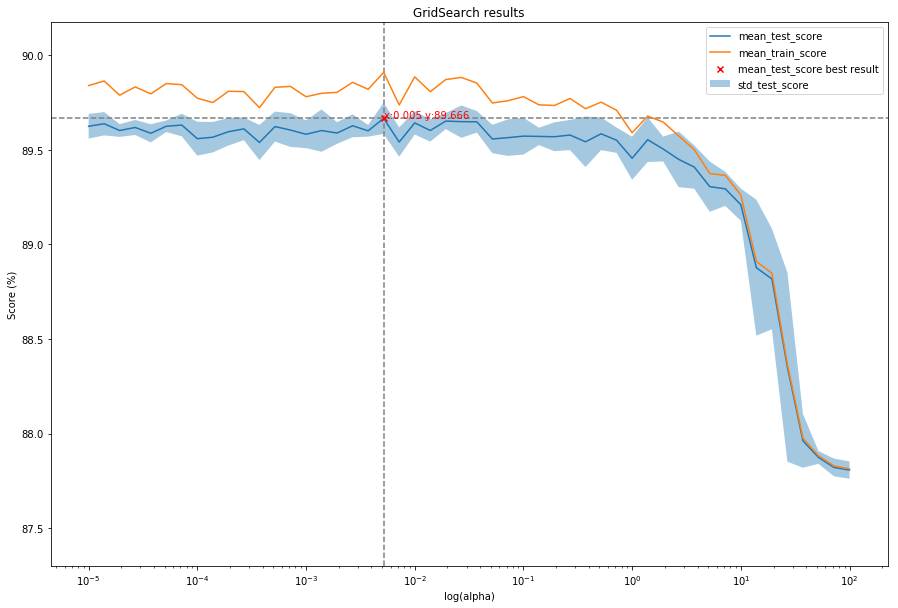

In [12]:
# Parameter name to plot
MODEL_PARAM='alpha'

# Plot train and validation curve
results_df=grid_df.sort_values(f'param_model__{MODEL_PARAM}')

plot_grid_search_results(results_df, x_param=f'param_model__{MODEL_PARAM}', semilogx=True, xlabel=MODEL_PARAM, std_factor=1)

# Prediction

Ok, now that we've found the best parameters and get the best estimator via *GridSearchCV()*, let's calculate the *mean_absolute_error* in km/h and %

In [13]:
# Get best estimator from grid search and predict using X_va
y_pred=grid_search.predict(X_va)

# Get the MAE from y_pred
print("MLPRegressor model mean absolute error         : {:.3f} km/h".format(mae(y_pred, y_va)))
print("MLPRegressor model mean absolute percent error : {:.2f} %".format(mape(y_pred, y_va)))




MLPRegressor model mean absolute error         : 1.295 km/h
MLPRegressor model mean absolute percent error : 89.45 %


# Save model


In [14]:
save_model(grid_search, 'mlp')

Saving model mlp to ./data/model-mlp.sav using 'pickle' library


## Here we are...

All models choosen for this project have been trained, it's time to display some results in the next Notebook: [Results and Communication](40.Results%20and%20Communication.ipynb).